In [79]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm

In [80]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),  
    transforms.ToTensor(),  
])

In [81]:
dataset = datasets.ImageFolder(root='dataset', transform=transform)

In [82]:
class_names = dataset.classes
class_names

['Beagle',
 'Boxer',
 'Bulldog',
 'Dachshund',
 'German_Shepherd',
 'Golden_Retriever',
 'Labrador_Retriever',
 'Poodle',
 'Rottweiler',
 'Yorkshire_Terrier']

In [83]:
img,labels = dataset[5]
input_shape = img.shape[0]
num_classes = len(dataset.classes)
(input_shape,num_classes)

(3, 10)

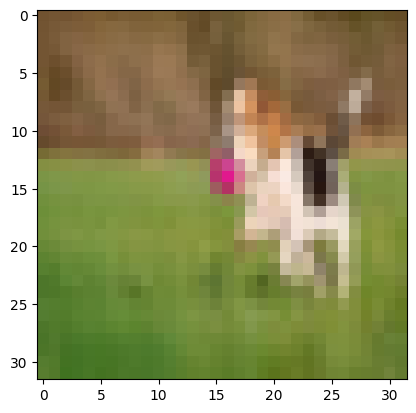

In [84]:
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()

In [85]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [86]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


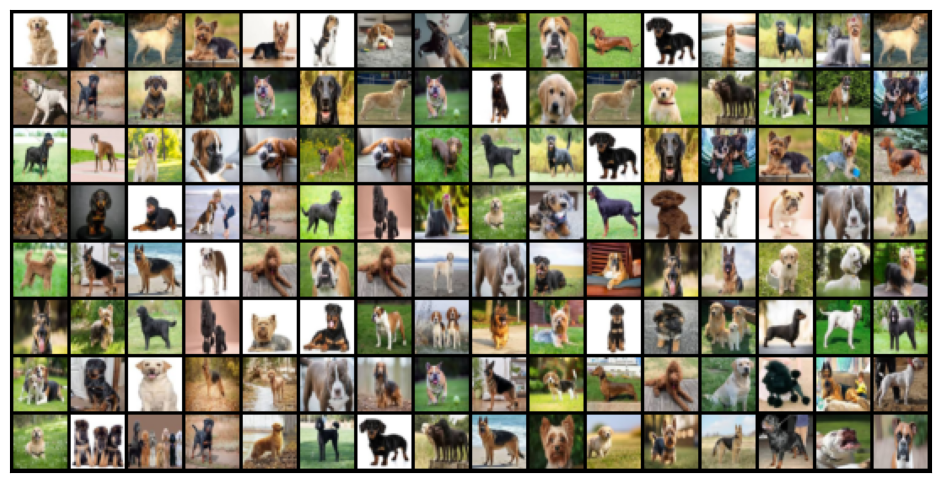

In [87]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break
show_batch(train_loader)

In [88]:
num_epochs = 100
lr = 0.001

In [89]:
def conv_block(in_channels,out_channels,pool=False):
    layers = [
        nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
    ]
    if pool:
        layers.append (nn.AvgPool2d(2))
    return nn.Sequential(*layers)

In [90]:
class ResNet(nn.Module):
    def __init__(self,in_channels,num_classes):
        super().__init__()
        # 3 x 32 x 32
        self.conv1 = conv_block(in_channels,64) # 64 x 32 x 32
        self.conv2 = conv_block(64,128,pool=True) #128 x 16 x 16
        self.res1 = nn.Sequential(conv_block(128,128),
                                  conv_block(128,128)
                                  ) # 128 x 16 x 16
        
        self.conv3 = conv_block(128,256,pool=True) # 256 x 8 x 8
        self.conv4 = conv_block(256,512,pool=True) #512 x 4 x 4
        self.res2 = nn.Sequential(conv_block(512,512),
                                  conv_block(512,512),
                                  ) # 512 x 4 x 4
        
        self.conv5 = conv_block(512,1028) # 1028 x 4 x 4
        self.conv6 = conv_block (1028,2056,pool=True) # 2056 x 2 x 2
        self.res3 = nn.Sequential(conv_block(2056,2056),
                                  conv_block(2056,2056)
                                  ) # 2056 x 2 x 2
        
        self.classifier = nn.Sequential (
            nn.AvgPool2d(2), # 2056 x 1 x 1
            nn.Flatten(), # 2056 
            nn.Dropout(0.2),
            nn.Linear(2056,num_classes)
        )
        
    def forward (self,xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.classifier(out)
        return out

In [91]:
device = torch.device('cuda')

In [92]:
model = ResNet(3, num_classes).to(device)

In [93]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=lr)


In [94]:
import matplotlib.pyplot as plt

def train(train_loader, model, criterion, optimizer, num_epochs):
    train_losses = []
    train_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        total_correct = 0
        total_samples = 0
        total_loss = 0.0
        train_loader = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            total_loss += loss.item()
        
        epoch_loss = total_loss / len(train_loader)
        epoch_acc = total_correct / total_samples * 100
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%')

    epochs = range(1, num_epochs + 1)
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'r', label='Training accuracy')
    plt.title('Training accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.show()



    
    
    
    
    

Epoch [1/100], Train Loss: 3.0820, Train Accuracy: 12.16%


Epoch [2/100], Train Loss: 2.4269, Train Accuracy: 19.15%


Epoch [3/100], Train Loss: 2.1980, Train Accuracy: 22.12%


Epoch [4/100], Train Loss: 2.0638, Train Accuracy: 27.94%


Epoch [5/100], Train Loss: 1.8165, Train Accuracy: 29.88%


Epoch [6/100], Train Loss: 1.7769, Train Accuracy: 34.93%


Epoch [7/100], Train Loss: 1.7132, Train Accuracy: 36.35%


Epoch [8/100], Train Loss: 1.5836, Train Accuracy: 42.30%


Epoch [9/100], Train Loss: 1.6523, Train Accuracy: 47.74%


Epoch [10/100], Train Loss: 1.4955, Train Accuracy: 47.61%


Epoch [11/100], Train Loss: 1.2805, Train Accuracy: 57.18%


Epoch [12/100], Train Loss: 1.2251, Train Accuracy: 53.43%


Epoch [13/100], Train Loss: 1.1280, Train Accuracy: 61.58%


Epoch [14/100], Train Loss: 0.9769, Train Accuracy: 64.55%


Epoch [15/100], Train Loss: 0.7830, Train Accuracy: 68.95%


Epoch [16/100], Train Loss: 0.9053, Train Accuracy: 73.74%


Epoch [17/100], Train Loss: 0.9986, Train Accuracy: 69.60%


Epoch [18/100], Train Loss: 1.0472, Train Accuracy: 73.61%


Epoch [19/100], Train Loss: 0.9629, Train Accuracy: 68.05%


Epoch [20/100], Train Loss: 0.8714, Train Accuracy: 72.83%


Epoch [21/100], Train Loss: 0.8237, Train Accuracy: 75.29%


Epoch [22/100], Train Loss: 0.9618, Train Accuracy: 74.77%


Epoch [23/100], Train Loss: 0.7281, Train Accuracy: 79.95%


Epoch [24/100], Train Loss: 0.6885, Train Accuracy: 77.88%


Epoch [25/100], Train Loss: 0.6676, Train Accuracy: 80.34%


Epoch [26/100], Train Loss: 0.6163, Train Accuracy: 82.92%


Epoch [27/100], Train Loss: 0.6867, Train Accuracy: 82.41%


Epoch [28/100], Train Loss: 1.3892, Train Accuracy: 76.33%


Epoch [29/100], Train Loss: 1.0624, Train Accuracy: 72.57%


Epoch [30/100], Train Loss: 1.1562, Train Accuracy: 71.02%


Epoch [31/100], Train Loss: 1.1737, Train Accuracy: 68.82%


Epoch [32/100], Train Loss: 0.9912, Train Accuracy: 78.14%


Epoch [33/100], Train Loss: 0.9953, Train Accuracy: 71.02%


Epoch [34/100], Train Loss: 0.8618, Train Accuracy: 74.51%


Epoch [35/100], Train Loss: 1.0387, Train Accuracy: 79.82%


Epoch [36/100], Train Loss: 0.6578, Train Accuracy: 82.41%


Epoch [37/100], Train Loss: 0.8697, Train Accuracy: 85.25%


Epoch [38/100], Train Loss: 0.6461, Train Accuracy: 80.98%


Epoch [39/100], Train Loss: 0.6634, Train Accuracy: 88.36%


Epoch [40/100], Train Loss: 0.6559, Train Accuracy: 81.89%


Epoch [41/100], Train Loss: 0.6796, Train Accuracy: 89.52%


Epoch [42/100], Train Loss: 0.6269, Train Accuracy: 81.63%


Epoch [43/100], Train Loss: 0.3376, Train Accuracy: 88.36%


Epoch [44/100], Train Loss: 0.3991, Train Accuracy: 94.83%


Epoch [45/100], Train Loss: 0.4200, Train Accuracy: 96.38%


Epoch [46/100], Train Loss: 0.7253, Train Accuracy: 92.76%


Epoch [47/100], Train Loss: 0.4069, Train Accuracy: 89.00%


Epoch [48/100], Train Loss: 0.6939, Train Accuracy: 87.45%


Epoch [49/100], Train Loss: 0.3722, Train Accuracy: 87.32%


Epoch [50/100], Train Loss: 0.3816, Train Accuracy: 90.56%


Epoch [51/100], Train Loss: 0.3601, Train Accuracy: 93.27%


Epoch [52/100], Train Loss: 0.3971, Train Accuracy: 93.14%


Epoch [53/100], Train Loss: 0.3434, Train Accuracy: 93.14%


Epoch [54/100], Train Loss: 0.5207, Train Accuracy: 91.72%


Epoch [55/100], Train Loss: 0.7876, Train Accuracy: 89.52%


Epoch [56/100], Train Loss: 0.4504, Train Accuracy: 88.62%


Epoch [57/100], Train Loss: 0.3930, Train Accuracy: 93.40%


Epoch [58/100], Train Loss: 0.5586, Train Accuracy: 90.82%


Epoch [59/100], Train Loss: 0.4666, Train Accuracy: 90.30%


Epoch [60/100], Train Loss: 0.2836, Train Accuracy: 93.40%


Epoch [61/100], Train Loss: 0.3738, Train Accuracy: 93.79%


Epoch [62/100], Train Loss: 0.2249, Train Accuracy: 93.27%


Epoch [63/100], Train Loss: 0.2830, Train Accuracy: 94.44%


Epoch [64/100], Train Loss: 0.2534, Train Accuracy: 95.21%


Epoch [65/100], Train Loss: 0.2364, Train Accuracy: 93.14%


Epoch [66/100], Train Loss: 0.2256, Train Accuracy: 96.25%


Epoch [67/100], Train Loss: 0.1792, Train Accuracy: 96.64%


Epoch [68/100], Train Loss: 0.3729, Train Accuracy: 95.21%


Epoch [69/100], Train Loss: 0.4445, Train Accuracy: 90.94%


Epoch [70/100], Train Loss: 0.4534, Train Accuracy: 93.01%


Epoch [71/100], Train Loss: 0.2176, Train Accuracy: 93.27%


Epoch [72/100], Train Loss: 0.1041, Train Accuracy: 97.41%


Epoch [73/100], Train Loss: 0.4374, Train Accuracy: 98.19%


Epoch [74/100], Train Loss: 0.3324, Train Accuracy: 97.02%


Epoch [75/100], Train Loss: 0.5281, Train Accuracy: 84.22%


Epoch [76/100], Train Loss: 0.2697, Train Accuracy: 91.46%


Epoch [77/100], Train Loss: 0.3637, Train Accuracy: 95.60%


Epoch [78/100], Train Loss: 0.4802, Train Accuracy: 96.51%


Epoch [79/100], Train Loss: 0.2127, Train Accuracy: 94.95%


Epoch [80/100], Train Loss: 0.2847, Train Accuracy: 95.47%


Epoch [81/100], Train Loss: 0.5179, Train Accuracy: 92.76%


Epoch [82/100], Train Loss: 0.4819, Train Accuracy: 89.13%


Epoch [83/100], Train Loss: 0.3925, Train Accuracy: 89.26%


Epoch [84/100], Train Loss: 0.4902, Train Accuracy: 90.17%


Epoch [85/100], Train Loss: 0.3834, Train Accuracy: 91.20%


Epoch [86/100], Train Loss: 0.2290, Train Accuracy: 92.50%


Epoch [87/100], Train Loss: 0.4351, Train Accuracy: 94.70%


Epoch [88/100], Train Loss: 0.3807, Train Accuracy: 92.37%


Epoch [89/100], Train Loss: 0.3049, Train Accuracy: 93.01%


Epoch [90/100], Train Loss: 0.2588, Train Accuracy: 94.95%


Epoch [91/100], Train Loss: 0.2204, Train Accuracy: 96.90%


Epoch [92/100], Train Loss: 0.4343, Train Accuracy: 96.90%


Epoch [93/100], Train Loss: 0.5135, Train Accuracy: 88.75%


Epoch [94/100], Train Loss: 0.2921, Train Accuracy: 96.38%


Epoch [95/100], Train Loss: 0.2589, Train Accuracy: 96.12%


Epoch [96/100], Train Loss: 0.2753, Train Accuracy: 93.27%


Epoch [97/100], Train Loss: 0.3432, Train Accuracy: 95.21%


Epoch [98/100], Train Loss: 0.2418, Train Accuracy: 97.02%


Epoch [99/100], Train Loss: 0.3682, Train Accuracy: 94.83%


Epoch [100/100], Train Loss: 0.4799, Train Accuracy: 95.73%


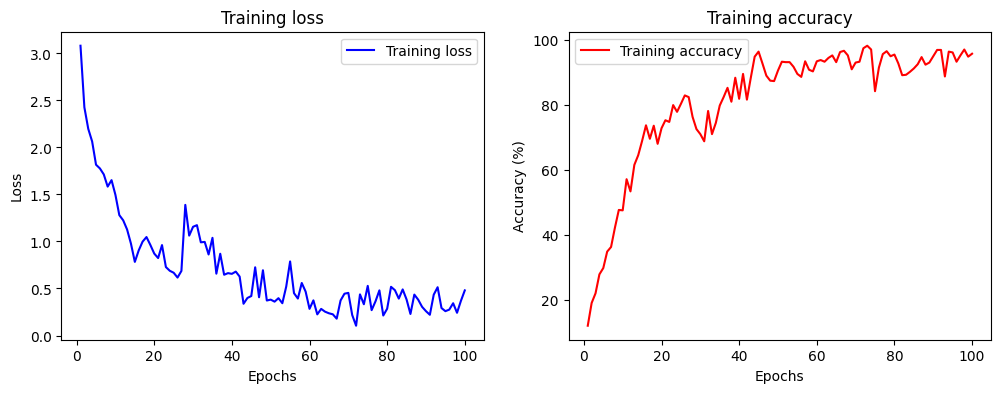

In [95]:
train(train_loader, model, criterion, optimizer, num_epochs)


In [96]:
torch.save(model.state_dict(), 'resnet_cnn.pth')


Accuracy: 0.97


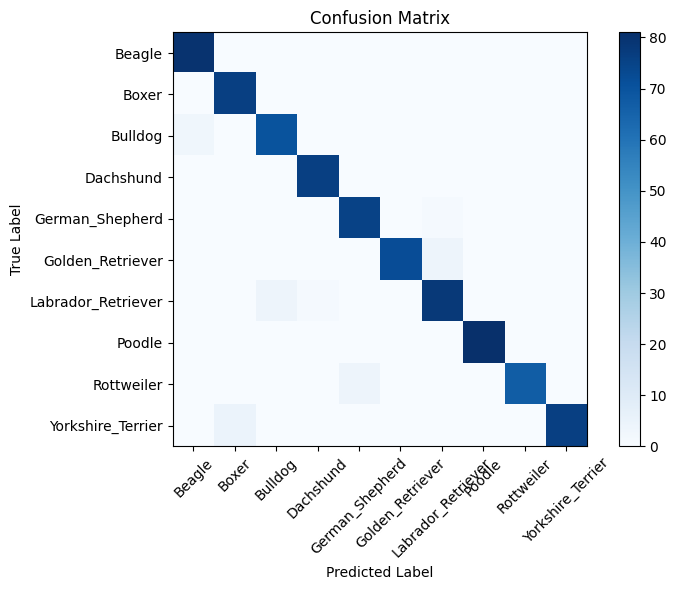

                    precision    recall  f1-score   support

            Beagle       0.96      1.00      0.98        80
             Boxer       0.94      1.00      0.97        76
           Bulldog       0.95      0.96      0.95        73
         Dachshund       0.99      1.00      0.99        76
   German_Shepherd       0.95      0.99      0.97        76
  Golden_Retriever       1.00      0.95      0.97        76
Labrador_Retriever       0.94      0.94      0.94        83
            Poodle       1.00      1.00      1.00        81
        Rottweiler       1.00      0.94      0.97        71
 Yorkshire_Terrier       1.00      0.94      0.97        81

          accuracy                           0.97       773
         macro avg       0.97      0.97      0.97       773
      weighted avg       0.97      0.97      0.97       773



In [97]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

predictions = np.array(predictions)
true_labels = np.array(true_labels)
accuracy = np.mean(predictions == true_labels)
print(f'Accuracy: {accuracy:.2f}')

class_names = dataset.classes
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

print(classification_report(true_labels, predictions, target_names=class_names))

Testing Accuracy: 0.98


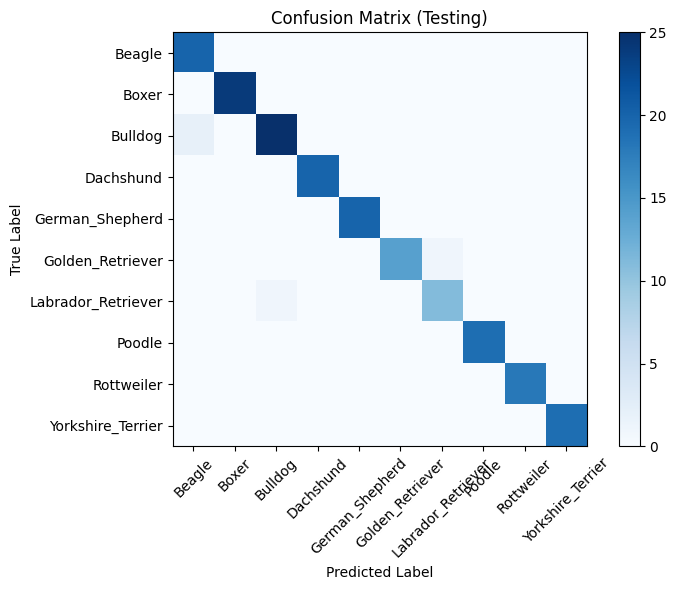

                    precision    recall  f1-score   support

            Beagle       0.91      1.00      0.95        20
             Boxer       1.00      1.00      1.00        24
           Bulldog       0.96      0.93      0.94        27
         Dachshund       1.00      1.00      1.00        20
   German_Shepherd       1.00      1.00      1.00        20
  Golden_Retriever       1.00      0.93      0.97        15
Labrador_Retriever       0.92      0.92      0.92        12
            Poodle       1.00      1.00      1.00        19
        Rottweiler       1.00      1.00      1.00        18
 Yorkshire_Terrier       1.00      1.00      1.00        19

          accuracy                           0.98       194
         macro avg       0.98      0.98      0.98       194
      weighted avg       0.98      0.98      0.98       194



In [98]:

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

predictions = np.array(predictions)
true_labels = np.array(true_labels)
accuracy = np.mean(predictions == true_labels)
print(f'Testing Accuracy: {accuracy:.2f}')

conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Testing)')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

print(classification_report(true_labels, predictions, target_names=class_names))

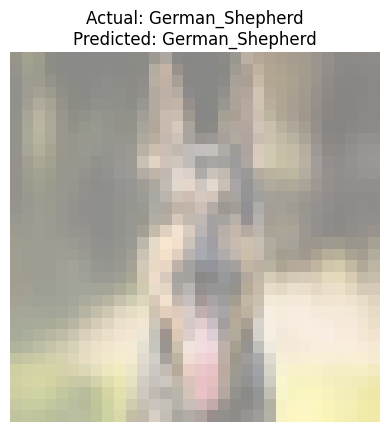

Image 105:
Actual class: German_Shepherd
Predicted class: German_Shepherd
------------------------


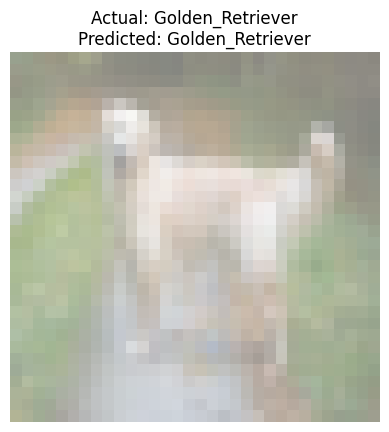

Image 162:
Actual class: Golden_Retriever
Predicted class: Golden_Retriever
------------------------


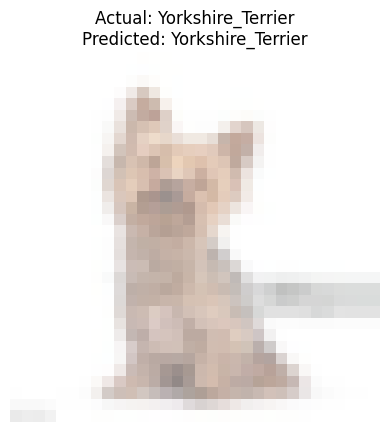

Image 9:
Actual class: Yorkshire_Terrier
Predicted class: Yorkshire_Terrier
------------------------


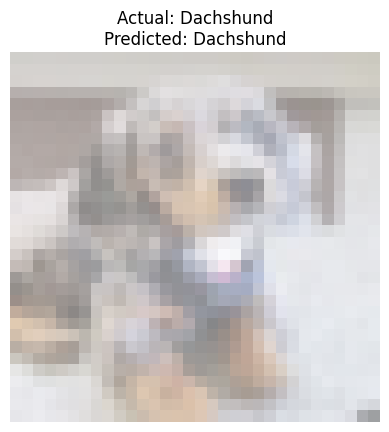

Image 115:
Actual class: Dachshund
Predicted class: Dachshund
------------------------


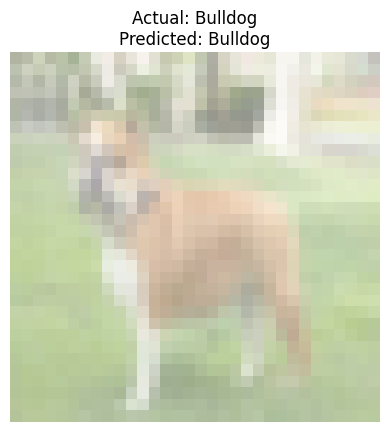

Image 180:
Actual class: Bulldog
Predicted class: Bulldog
------------------------


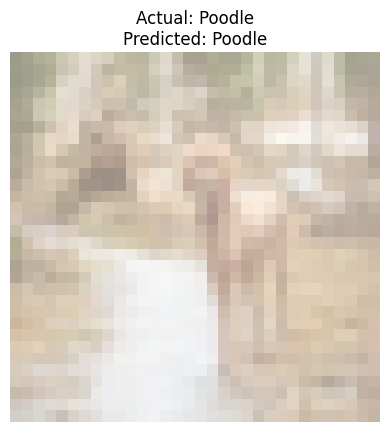

Image 70:
Actual class: Poodle
Predicted class: Poodle
------------------------


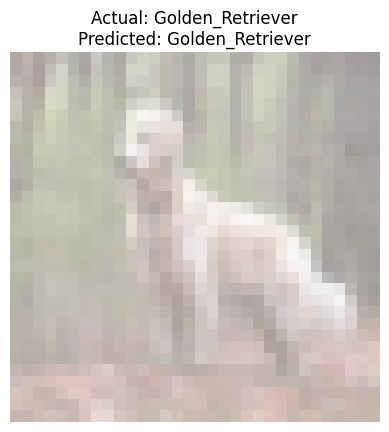

Image 13:
Actual class: Golden_Retriever
Predicted class: Golden_Retriever
------------------------


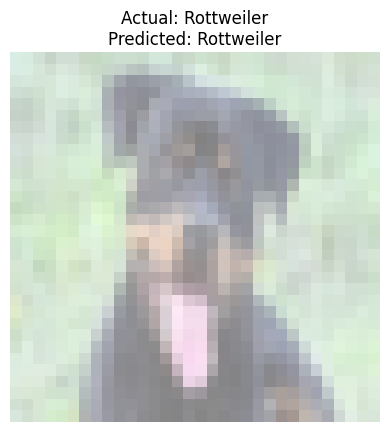

Image 139:
Actual class: Rottweiler
Predicted class: Rottweiler
------------------------


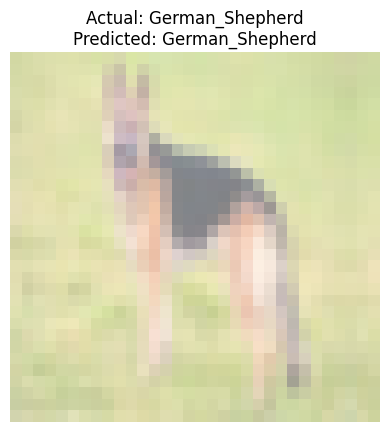

Image 45:
Actual class: German_Shepherd
Predicted class: German_Shepherd
------------------------


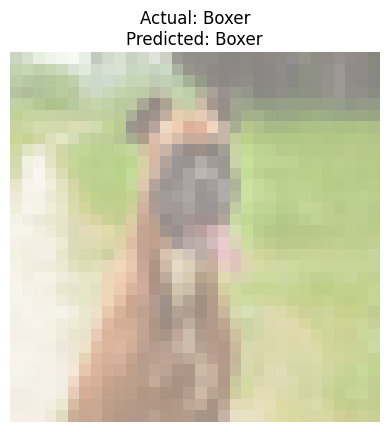

Image 1:
Actual class: Boxer
Predicted class: Boxer
------------------------


In [99]:
import torch
import matplotlib.pyplot as plt
import random
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()



def imshow(img):
    img = img.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

total_images = len(test_loader.dataset)

random_indices = random.sample(range(total_images), 10)

for idx in random_indices:
    image, label = test_loader.dataset[idx]
    
    image = image.unsqueeze(0).to(device)
    label = torch.tensor(label).to(device)

    with torch.no_grad():
        output = model(image)
    
    _, predicted = torch.max(output, 1)

    plt.figure()
    imshow(image.squeeze(0).cpu())
    plt.title(f"Actual: {class_names[label.item()]}\nPredicted: {class_names[predicted.item()]}")
    plt.show()

    print(f"Image {idx}:")
    print(f"Actual class: {class_names[label.item()]}")
    print(f"Predicted class: {class_names[predicted.item()]}")
    print("------------------------")

In [100]:
from PIL import Image
import torch
import torchvision.transforms as transforms

def predict_image_class(image_path, model, class_names):
    image_path = "images/" + image_path
    entered_image = Image.open(image_path)

    
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ])

    transformed_image = transform(entered_image).unsqueeze(0)  

    
    model.eval()

    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transformed_image = transformed_image.to(device)

    
    with torch.no_grad():
        outputs = model(transformed_image)

    
    _, predicted = torch.max(outputs, 1)
    predicted_class = predicted.item()  

    
    probs = torch.softmax(outputs, dim=1)
    predicted_prob = probs[0, predicted_class].item()

    print(f'Predicted Class: {class_names[predicted_class]}, Probability: {predicted_prob:.2f}')
    
    plt.imshow(entered_image)
    plt.show()


Predicted Class: Rottweiler, Probability: 0.79


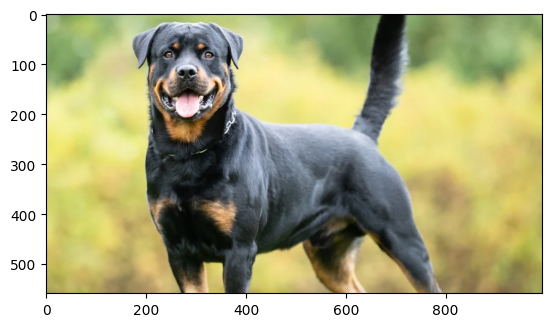

In [101]:
predict_image_class('img1.jpg', model, class_names)

Predicted Class: German_Shepherd, Probability: 1.00


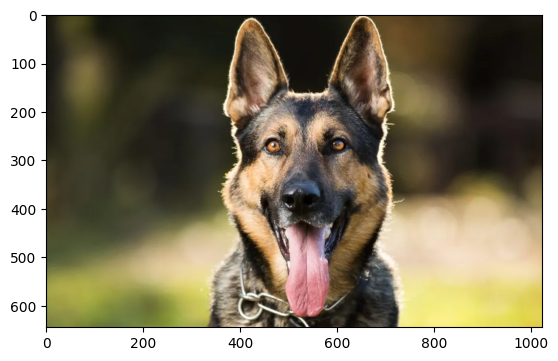

In [102]:
predict_image_class('img2.jpg', model, class_names)

In [103]:
class_names

['Beagle',
 'Boxer',
 'Bulldog',
 'Dachshund',
 'German_Shepherd',
 'Golden_Retriever',
 'Labrador_Retriever',
 'Poodle',
 'Rottweiler',
 'Yorkshire_Terrier']

Predicted Class: Golden_Retriever, Probability: 0.87


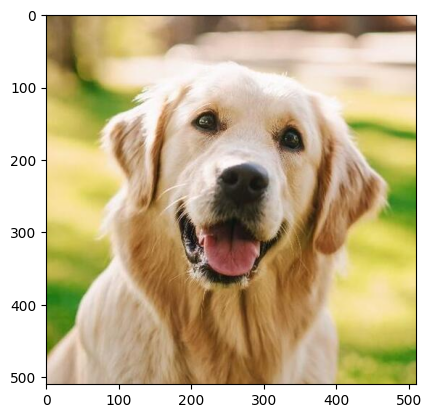

In [104]:
predict_image_class('img3.jpg', model, class_names)